<a href="https://colab.research.google.com/github/Keita-Koyama/q-macro/blob/main/%E5%BE%8C%E5%8D%8A%E8%AA%B2%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transition matrix (pi):
 [[0.5083107  0.4916893 ]
 [0.06954789 0.93045211]]
Productivity states (h):
 [0.30727874 0.8025188 ]


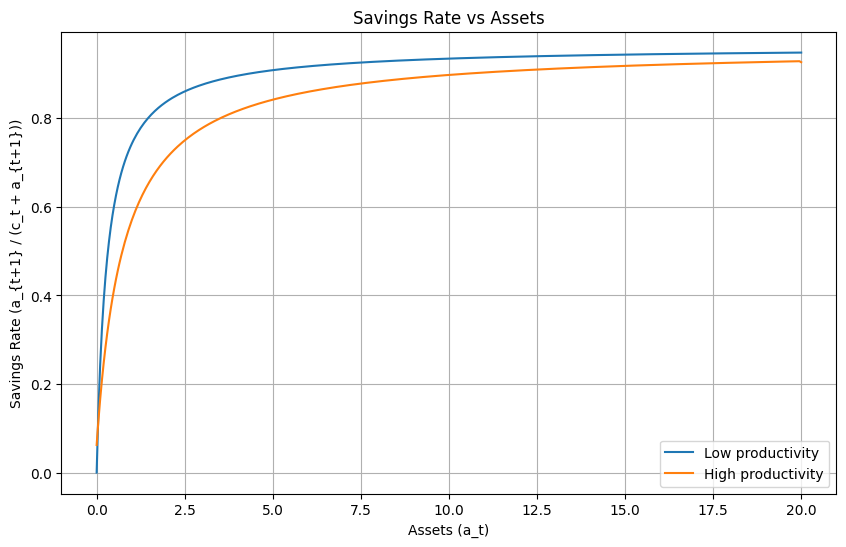

In [7]:
#1
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[n-1] - state_space[0]) / (n-1)
    transition_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2) / sigma)
            elif j == n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2) / sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2) / sigma)
    return transition_matrix, state_space

def setPar(sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.384, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)
    param = {
        'sigma': sigma,
        'beta': beta,
        'pi': pi,
        'h': h,
        'NA': NA,
        'NH': NH,
        'a_l': a_l,
        'a_u': a_u
    }
    return param

param = setPar()
print("Transition matrix (pi):\n", param['pi'])
print("Productivity states (h):\n", param['h'])
def solve_household(param, r=0.04, w=1):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']
    a = np.linspace(a_l, a_u, NA)
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0 - sigma) / (1.0 - sigma)
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])
        test = np.max(abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + r) * a[ia] - aplus[ia, ih]
    return aplus, iaplus, c

param = setPar()
aplus, iaplus, c = solve_household(param)
a = np.linspace(param['a_l'], param['a_u'], param['NA'])

plt.figure(figsize=(10, 6))
plt.plot(a, aplus[:, 0] / (c[:, 0] + aplus[:, 0]), label='Low productivity', linestyle='-')
plt.plot(a, aplus[:, 1] / (c[:, 1] + aplus[:, 1]), label='High productivity', linestyle='-')
plt.xlabel("Assets (a_t)")
plt.ylabel("Savings Rate (a_{t+1} / (c_t + a_{t+1}))")
plt.title("Savings Rate vs Assets")
plt.legend()
plt.grid(True)
plt.show()



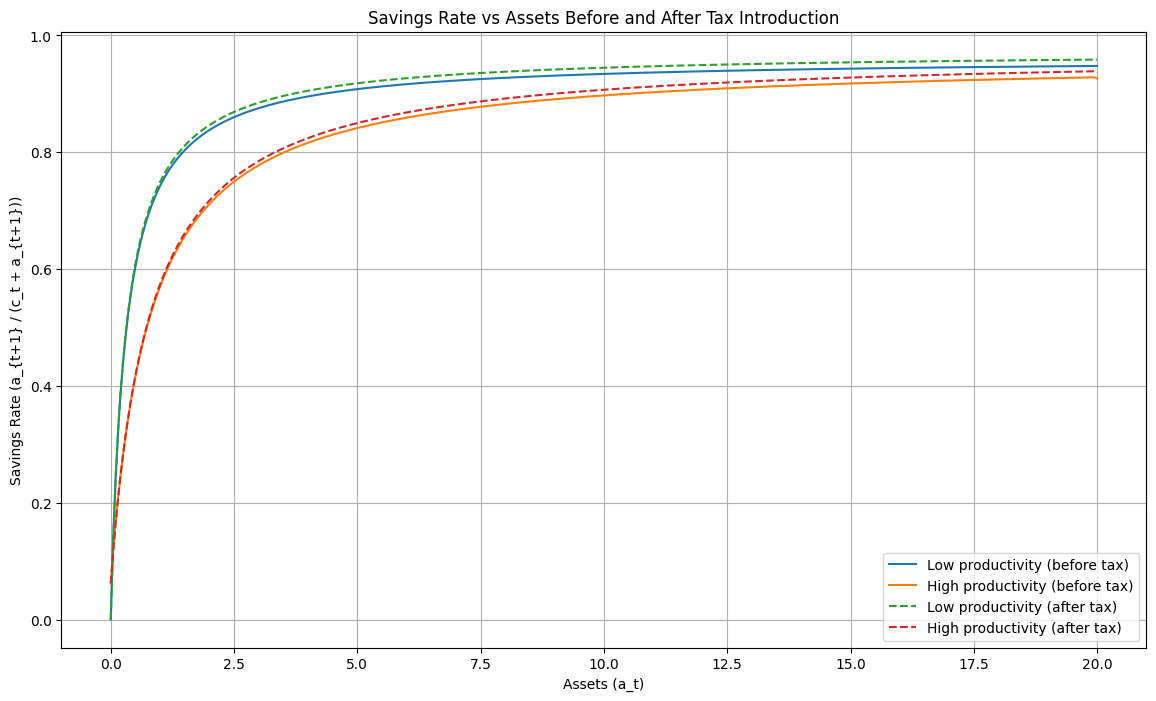

In [11]:
def solve_household(param, r=0.04, w=1):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']
    a = np.linspace(a_l, a_u, NA)
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0 - sigma) / (1.0 - sigma)
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])
        test = np.max(abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + r) * a[ia] - aplus[ia, ih]
    return aplus, iaplus, c

def solve_household_with_tax(param, tau_r, r=0.04, w=1):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']
    a = np.linspace(a_l, a_u, NA)
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + (1 - tau_r) * r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0 - sigma) / (1.0 - sigma)
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])
        test = np.max(abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + (1 - tau_r) * r) * a[ia] - aplus[ia, ih]
    return aplus, iaplus, c

param = setPar()
tau_r = 0.3  # 資本所得税率を設定
aplus, iaplus, c = solve_household(param)
aplus_tax, iaplus_tax, c_tax = solve_household_with_tax(param, tau_r)
a = np.linspace(param['a_l'], param['a_u'], param['NA'])

# 資本所得税導入前後の貯蓄率プロット
plt.figure(figsize=(14, 8))
plt.plot(a, aplus[:, 0] / (c[:, 0] + aplus[:, 0]), label='Low productivity (before tax)', linestyle='-')
plt.plot(a, aplus[:, 1] / (c[:, 1] + aplus[:, 1]), label='High productivity (before tax)', linestyle='-')
plt.plot(a, aplus_tax[:, 0] / (c_tax[:, 0] + aplus_tax[:, 0]), label='Low productivity (after tax)', linestyle='--')
plt.plot(a, aplus_tax[:, 1] / (c_tax[:, 1] + aplus_tax[:, 1]), label='High productivity (after tax)', linestyle='--')
plt.xlabel("Assets (a_t)")
plt.ylabel("Savings Rate (a_{t+1} / (c_t + a_{t+1}))")
plt.title("Savings Rate vs Assets Before and After Tax Introduction")
plt.legend()
plt.grid(True)
plt.show()


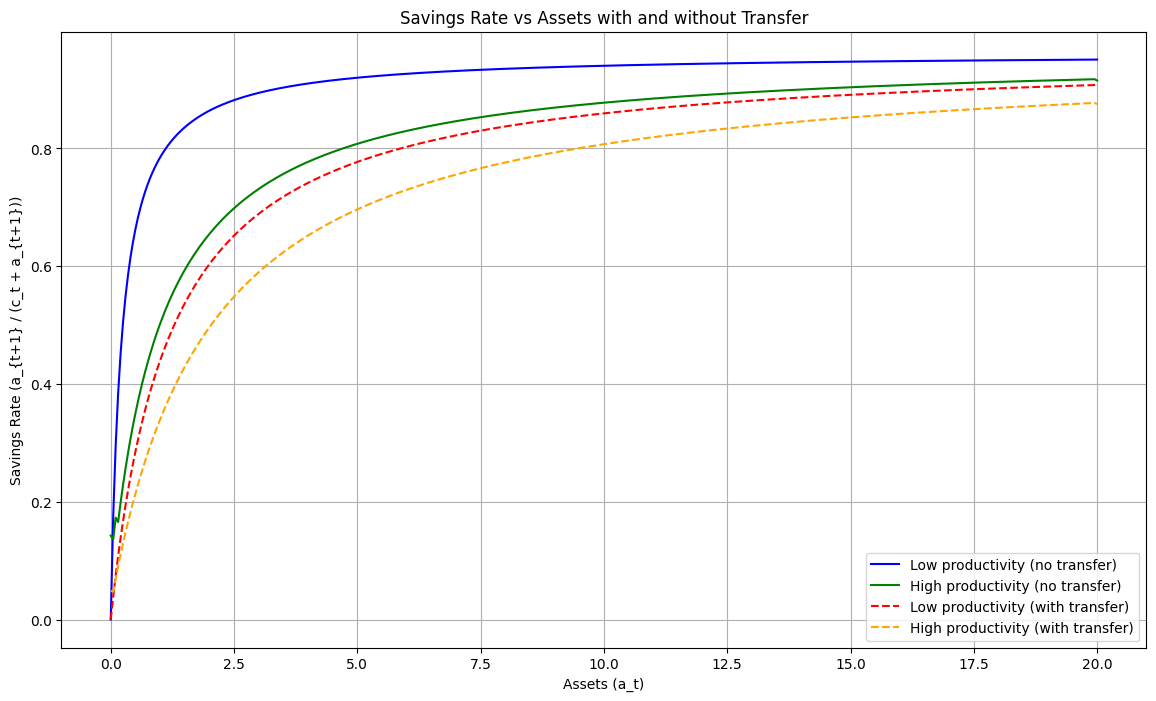

In [13]:
#3
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[n-1] - state_space[0]) / (n-1)
    transition_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2) / sigma)
            elif j == n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2) / sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2) / sigma)
    return transition_matrix, state_space

def setPar(sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)
    param = {
        'sigma': sigma,
        'beta': beta,
        'pi': pi,
        'h': h,
        'NA': NA,
        'NH': NH,
        'a_l': a_l,
        'a_u': a_u
    }
    return param

def solve_household_with_transfer(param, T, r=0.04, w=1):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']
    a = np.linspace(a_l, a_u, NA)
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + r) * a[ia] + T - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0 - sigma) / (1.0 - sigma)
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])
        test = np.max(abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + r) * a[ia] + T - aplus[ia, ih]
    return aplus, iaplus, c

# パラメータ設定
param = setPar()
T = 1  # 一括補助金の額を設定

# 一括補助金導入前の貯蓄率を計算
aplus, iaplus, c = solve_household_with_transfer(param, 0)

# 一括補助金導入後の貯蓄率を計算
aplus_transfer, iaplus_transfer, c_transfer = solve_household_with_transfer(param, T)

a = np.linspace(param['a_l'], param['a_u'], param['NA'])

# グラフをプロット
plt.figure(figsize=(14, 8))
plt.plot(a, aplus[:, 0] / (c[:, 0] + aplus[:, 0]), label='Low productivity (no transfer)', color='blue')
plt.plot(a, aplus[:, 1] / (c[:, 1] + aplus[:, 1]), label='High productivity (no transfer)', color='green')
plt.plot(a, aplus_transfer[:, 0] / (c_transfer[:, 0] + aplus_transfer[:, 0]), label='Low productivity (with transfer)', color='red',linestyle='--')
plt.plot(a, aplus_transfer[:, 1] / (c_transfer[:, 1] + aplus_transfer[:, 1]), label='High productivity (with transfer)', color='orange',linestyle='--')
plt.xlabel("Assets (a_t)")
plt.ylabel("Savings Rate (a_{t+1} / (c_t + a_{t+1}))")
plt.title("Savings Rate vs Assets with and without Transfer")
plt.legend()
plt.grid(True)
plt.show()


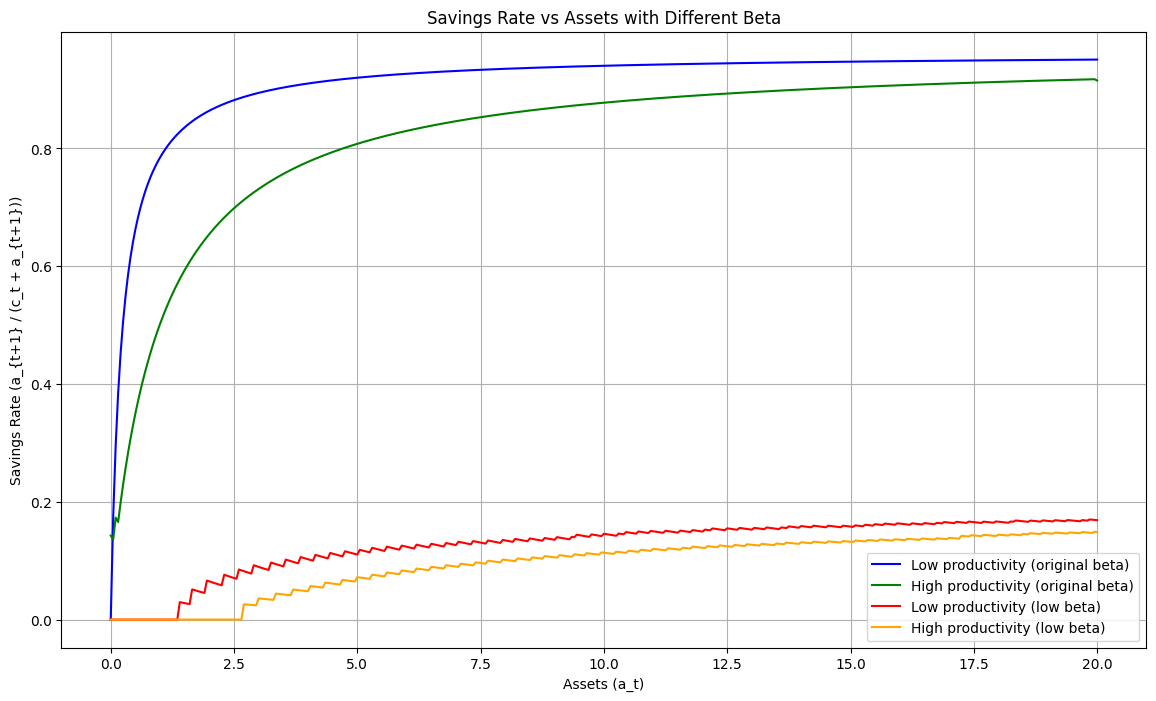

In [14]:
#4
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[n-1] - state_space[0]) / (n-1)
    transition_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2) / sigma)
            elif j == n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2) / sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2) / sigma)
    return transition_matrix, state_space

def setPar(sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)
    param = {
        'sigma': sigma,
        'beta': beta,
        'pi': pi,
        'h': h,
        'NA': NA,
        'NH': NH,
        'a_l': a_l,
        'a_u': a_u
    }
    return param

def solve_household(param, beta=None, r=0.04, w=1):
    if beta is None:
        beta = param['beta']

    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    pi = param['pi']
    a = np.linspace(a_l, a_u, NA)
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0 - sigma) / (1.0 - sigma)
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])
        test = np.max(abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + r) * a[ia] - aplus[ia, ih]
    return aplus, iaplus, c

# パラメータ設定
param = setPar(beta=0.98, sigma_eps=0.6)
aplus, iaplus, c = solve_household(param)

# 低βのケース
param_low_beta = setPar(beta=0.1, sigma_eps=0.6)
aplus_low_beta, iaplus_low_beta, c_low_beta = solve_household(param_low_beta, beta=0.1)

a = np.linspace(param['a_l'], param['a_u'], param['NA'])

# グラフをプロット
plt.figure(figsize=(14, 8))
plt.plot(a, aplus[:, 0] / (c[:, 0] + aplus[:, 0]), label='Low productivity (original beta)', color='blue')
plt.plot(a, aplus[:, 1] / (c[:, 1] + aplus[:, 1]), label='High productivity (original beta)', color='green')
plt.plot(a, aplus_low_beta[:, 0] / (c_low_beta[:, 0] + aplus_low_beta[:, 0]), label='Low productivity (low beta)', color='red')
plt.plot(a, aplus_low_beta[:, 1] / (c_low_beta[:, 1] + aplus_low_beta[:, 1]), label='High productivity (low beta)', color='orange')
plt.xlabel("Assets (a_t)")
plt.ylabel("Savings Rate (a_{t+1} / (c_t + a_{t+1}))")
plt.title("Savings Rate vs Assets with Different Beta")
plt.legend()
plt.grid(True)
plt.show()
